In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit import QuantumRegister, Qubit, Gate, ClassicalRegister
from qiskit.aqua.components.oracles import Oracle, TruthTableOracle
from qiskit.quantum_info import Statevector

#import utils
from collections import OrderedDict

import math
import numpy as np

# Import general libraries (needed for functions)
import numpy as np
import time

# Import Qiskit classes
import qiskit
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

from qiskit.test.mock import FakeYorktown #, FakeCasablanca

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
provider = IBMQ.get_provider(hub='ibm-q-research', group='Pablo-Antonio-Mo', project='main') 
print(provider)
backends = provider.backends()
for backend in backends:
    print(backend.name())
    
backend = provider.backends(name = 'ibmqx2')[0]
#backend = FakeYorktown()

<AccountProvider for IBMQ(hub='ibm-q-research', group='Pablo-Antonio-Mo', project='main')>
ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_vigo
ibmq_ourense
ibmq_valencia
ibmq_armonk
ibmq_athens
ibmq_rome
ibmq_santiago
ibmq_bogota
ibmq_casablanca


In [3]:
import json
with open('delta_energies_glycylglycine_1_random.json') as json_file:
    data = json.load(json_file)

deltas_dictionary = data['deltas']
deltas_dictionary = OrderedDict(sorted(deltas_dictionary.items()))
print(len(deltas_dictionary))
deltas = {}
for (key,value) in deltas_dictionary.items():
    deltas[key[:3]] = value
    #print(key,value)
print('corrected ------------------')
for (key,value) in deltas.items():
    print(key, value)

16
corrected ------------------
000 -0.7599604162252263
001 -0.43577938756914136
010 -0.491037486578648
011 0.43577938756914136
100 0.7599604162252263
101 -0.1668564579225631
110 0.491037486578648
111 0.1668564579225631


In [4]:
# Bitmap calculation
def calculate_angles(deltas_dictionary, beta = 1, scaling_factor = 1000):
    
    exact_angles = {}

    for key in deltas_dictionary.keys():

        if deltas_dictionary[key] >= 0:

            if scaling_factor == -1:
                probability = math.exp(-beta * deltas_dictionary[key])
            else:
                probability = math.exp(-scaling_factor* beta * deltas_dictionary[key])
        else: 
            probability = 1
        # Instead of encoding the angle corresponding to the probability, we will encode the angle theta such that sin^2(pi/2 - theta) = probability.
        # That way 1 -> 000, but if probability is 0 there is some small probability of acceptance

        # Instead of probability save angles so rotations are easier to perform afterwards sqrt(p) = sin(pi/2-theta/2).
        # The theta/2 is because if you input theta, qiskits rotates theta/2. Also normalised (divided between pi the result)
        exact_angles[key] = math.pi - 2 * math.asin(math.sqrt(probability))


    # Order angles by key
    exact_angles = OrderedDict(sorted(exact_angles.items()))

    return exact_angles

In [5]:
# This is a parameter that calculates the precision in the rotations
n_ancilla_bits = 0

Let us have some error correction in place

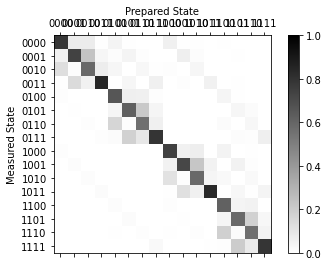

In [6]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(4+n_ancilla_bits)
qubit_list = range(4+n_ancilla_bits)
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

def insert_spaces(string):
    new_str = string[0]
    for item in string[1:-1]:
        new_str += ' '+ item
    new_str += ' ' + string[-1]
    return new_str

job = qiskit.execute(meas_calibs, backend=backend, shots=1024)
cal_results = job.result()

# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

Let us first construct the substitute of the oracle

In [7]:

angles = calculate_angles(deltas_dictionary = deltas, beta = 1, scaling_factor = 1)
print(angles)

def new_coin_flip(circuit,coin,move_id,angle_psi,angle_phi,angles,inverse):
    ''' Applies the controlled rotation to the target coin. Substitutes the oracle'''
    if inverse == 1:
        circuit.x(coin)
    
    if angles['111'] > .1:
        circuit.mcrx(theta = -inverse * angles['111'], q_controls = [move_id[0],angle_psi[0],angle_phi[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_phi)
    
    if angles['110'] > .1:
        circuit.mcrx(theta = -inverse * angles['110'], q_controls = [move_id[0],angle_psi[0],angle_phi[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_psi)
    
    if angles['100'] > .1:
        circuit.mcrx(theta = -inverse * angles['100'], q_controls = [move_id[0],angle_psi[0],angle_phi[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_phi)
    
    if angles['101'] > .1:
        circuit.mcrx(theta = -inverse * angles['101'], q_controls = [move_id[0],angle_psi[0],angle_phi[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(move_id)
    
    if angles['001'] > .1:
        circuit.mcrx(theta = -inverse * angles['001'], q_controls = [move_id[0],angle_psi[0],angle_phi[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_phi)
    
    if angles['000'] > .1:
        circuit.mcrx(theta = -inverse * angles['000'], q_controls = [move_id[0],angle_psi[0],angle_phi[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_psi)
    
    if angles['010'] > .1:
        circuit.mcrx(theta = -inverse * angles['010'], q_controls = [move_id[0],angle_psi[0],angle_phi[0]], q_target = coin[0], use_basis_gates=False)
    circuit.x(angle_phi)
    
    if angles['011'] > .1:
        circuit.mcrx(theta = -inverse * angles['011'], q_controls = [move_id[0],angle_psi[0],angle_phi[0]], q_target = coin[0], use_basis_gates=False) 
    circuit.x(move_id)
    
    if inverse == -1:
        circuit.x(coin)

OrderedDict([('000', 0.0), ('001', 0.0), ('010', 0.0), ('011', 1.2728885468441173), ('100', 1.6354715267243518), ('101', 0.0), ('110', 1.3448976833778248), ('111', 0.8056505242148093)])


The quantum Walk is composed of several parts, $$W = R V^\dagger B^\dagger F B V,$$
where $V$ prepares possible moves, $B$ is the Boltzmann coin, $F$ the coin flip, and $R$ a reflection of all registers except the state one over state $\ket{0}$. The first thing we do is prepare the oracle


In [8]:
def W_step(qc,coin,move_id,angle_psi,angle_phi,angles): 
    # Perform the preparation of possible moves----
    qc.h(move_id)

    # Prepare the Boltzmann coin ------------------
    new_coin_flip(qc,coin,move_id,angle_psi,angle_phi,angles,inverse = 1)
    
    # Perform move ---------------------------------
    # For the second angle
    qc.ccx(coin,move_id,angle_psi)

    # For the first angle
    qc.x(move_id)
    qc.ccx(coin,move_id,angle_phi)
    qc.x(move_id)

    # Prepare the Boltzmann coin--------------------
    new_coin_flip(qc,coin,move_id,angle_psi,angle_phi,angles,inverse = -1)

    # Perform the preparation of possible moves ----
    qc.h(move_id)

    #Reflection -------------------------------------
    qc.x(move_id)
    qc.x(coin)

    # Perform a multicontrolled Z
    qc.cz(move_id,coin)
    
    qc.x(move_id)
    qc.x(coin)

Running the model on a backend

In [9]:
move_id  = QuantumRegister(1)
angle_phi = QuantumRegister(1)
angle_psi = QuantumRegister(1)
coin = QuantumRegister(1)
c_reg = ClassicalRegister(4+ n_ancilla_bits)
qc = QuantumCircuit(coin,move_id,angle_psi,angle_phi,c_reg)

number_W = 2 # Parameter

#Circuit ----------
qc.h(angle_phi)
qc.h(angle_psi)
for i in range(number_W):
    W_step(qc,coin,move_id,angle_psi,angle_phi,angles)

# Measure
qc.measure(range(n_ancilla_bits + 4), range(n_ancilla_bits + 4))

# Transpiling -------
print('Before optimization-------')
qc = transpile(qc, seed_transpiler=1, optimization_level=0)
print('gates = ', qc.count_ops())
print('depth = ', qc.depth())
qc = transpile(qc, backend = backend, seed_transpiler=1, optimization_level=3)
print('After optimization--------')
print('gates = ', qc.count_ops())
print('depth = ', qc.depth())

job = execute(qc, backend, shots=8192)
results = job.result()

# Results without mitigation
raw_counts = results.get_counts()
print(raw_counts)

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

Before optimization-------
gates =  OrderedDict([('cu3', 112), ('cx', 96), ('x', 48), ('h', 6), ('ccx', 4), ('measure', 4), ('cz', 2)])
depth =  237
After optimization--------
gates =  OrderedDict([('cx', 520), ('u3', 257), ('u2', 181), ('u1', 32), ('measure', 4), ('barrier', 1)])
depth =  703
{'0000': 557, '0001': 742, '0010': 270, '0011': 346, '0100': 427, '0101': 675, '0110': 232, '0111': 409, '1000': 485, '1001': 685, '1010': 486, '1011': 666, '1100': 432, '1101': 631, '1110': 407, '1111': 742}


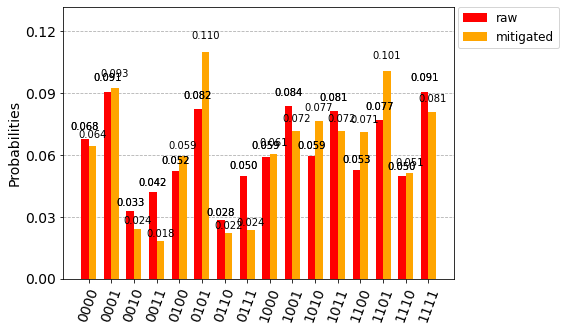

In [10]:
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'], color = ['red','orange'])

The same circuit without error can be seen in

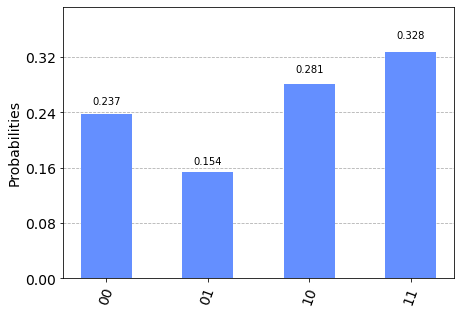

In [11]:
move_id  = QuantumRegister(1)
angle_phi = QuantumRegister(1)
angle_psi = QuantumRegister(1)
coin = QuantumRegister(1)
c_reg = ClassicalRegister(4+n_ancilla_bits)
qc = QuantumCircuit(coin,move_id,angle_psi,angle_phi,c_reg)


#Circuit ----------
qc.h(angle_phi)
qc.h(angle_psi)
for i in range(number_W):
    W_step(qc,coin,move_id,angle_psi,angle_phi,angles)
    
# Measure
backend = Aer.get_backend('statevector_simulator')
backend_options = {"method" : "statevector"}
experiment = execute(qc, backend, backend_options=backend_options)
state_vector = Statevector(experiment.result().get_statevector(qc))

probabilities = state_vector.probabilities([2,3])
noiseless_counts = {}
noiseless_counts['00'] = float(probabilities[0])
noiseless_counts['01'] = float(probabilities[1])
noiseless_counts['10'] = float(probabilities[2])
noiseless_counts['11'] = float(probabilities[3])

from qiskit.visualization import plot_histogram
plot_histogram(noiseless_counts)

In [12]:
def calc_probabilities(counts):
    'Calculates the probabilities when measuring the first two qubits'
    new_counts = {}
    for i in ['00','01','10','11']:
        new_counts[i] = 0
    for item in counts:
        new_counts[item[0] + item[1]] += counts[item]
    return new_counts
counts = {'0000':1, '0010':1}
new_counts = calc_probabilities(counts)
new_counts

{'00': 2, '01': 0, '10': 0, '11': 0}

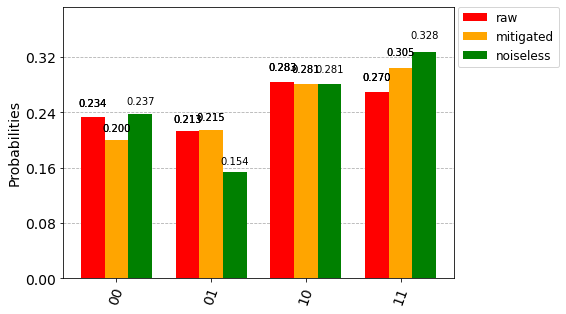

In [13]:
plot_histogram([calc_probabilities(raw_counts), calc_probabilities(mitigated_counts),noiseless_counts], legend=['raw', 'mitigated','noiseless'], color = ['red','orange','green'])

In [14]:
print(angles)

OrderedDict([('000', 0.0), ('001', 0.0), ('010', 0.0), ('011', 1.2728885468441173), ('100', 1.6354715267243518), ('101', 0.0), ('110', 1.3448976833778248), ('111', 0.8056505242148093)])
